<a href="https://colab.research.google.com/github/audreymcmillion/ml-classchallenge/blob/main/TASK2_bestmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

# DO NOT EDIT THIS FILE! CONTAINS THE BEST MODEL SO FAR WITH OUTPUTS!

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.__version__

Num GPUs Available:  1


'2.8.0'

In [ ]:
# cloning into the repo where the data is stored
!git clone https://github.com/audreymcmillion/ml-classchallenge.git

fatal: destination path 'ml-classchallenge' already exists and is not an empty directory.


#### Load Image Data

In [ ]:
DATA_LIST = os.listdir('ml-classchallenge/all/train')
DATASET_PATH  = 'ml-classchallenge/all/train'
TEST_DIR =  'ml-classchallenge/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 13  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.001 # start off with high rate first 0.001 and experiment with reducing it gradually 

In [ ]:
import cv2
def preprocessing_fun(img):
    # convert to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.uint8)
    
    # The declaration of CLAHE
    # clipLimit -> Threshold for contrast limiting
    clahe = cv2.createCLAHE(clipLimit = 5)
    final_img = clahe.apply(gray_image)
    final_img = cv2.GaussianBlur(final_img,(5,5),0)
    final_img = final_img.reshape((224,224,1))
    return tf.image.grayscale_to_rgb(tf.convert_to_tensor(final_img, dtype=tf.float16))

In [ ]:
import glob
from PIL import Image
from pathlib import Path

################################################
## FUNCTIONS FOR PULLING TRAINING
## DATASET INTO NUMPY ARRAY
## FOR FEATUREWISE CENTERING/STD NORMALIZATION
## source: https://stackoverflow.com/questions/55663880/how-to-use-featurewise-center-true-together-with-flow-from-directory-in-imagedat
################################################

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext = ['jpeg', 'png', 'jpg']):
    full_list = []
    for ext in img_ext:
      part1 = [read_pil_image(str(p), height, width) for p in 
                                      Path(dataset_path + '/covid/').rglob("*."+ext)]
      part2 = [read_pil_image(str(p), height, width) for p in 
                                      Path(dataset_path + '/normal/').rglob("*."+ext)]
      part3 = [read_pil_image(str(p), height, width) for p in 
                                      Path(dataset_path + '/pnuemonia_bac/').rglob("*."+ext)]
      part4 = [read_pil_image(str(p), height, width) for p in 
                                      Path(dataset_path + '/pnuemonia_vir/').rglob("*."+ext)]

      full_list = full_list + part1 + part2 + part3 + part4
    return np.array(full_list)

#### Generate Training and Validation Batches

In [ ]:
#import preprocess_crop #https://gist.github.com/rstml/bbd491287efc24133b90d4f7f3663905#file-preprocess_crop-py

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, featurewise_center = True,
                                   featurewise_std_normalization = True, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.25, zoom_range=0.1,
                                   zca_whitening = False, channel_shift_range = 20,
                                   horizontal_flip = True, vertical_flip = False,
                                   preprocessing_function = preprocessing_fun,
                                   validation_split = 0.2, fill_mode='constant')

# fit the data augmentation
train_datagen.fit(load_all_images(DATASET_PATH, 224, 224))

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical",
                                                  interpolation = 'nearest')

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical",
                                                  interpolation = 'nearest')

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [ ]:
from tensorflow.keras.applications import DenseNet121,VGG16,VGG19
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,GaussianNoise
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers


# model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(224,224, 1)) 
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224, 3))
# base_model.trainable = False 
base_model.trainable = True ## trainable weights

# see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# start at a high level, see if there's any improvement
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# pool1=GlobalAveragePooling2D()
batch1=BatchNormalization()
flatten_layer = Flatten()
dropout1=Dropout(0.5)
dropout2=Dropout(0.2)
dense1=Dense(1024,activation='swish')
dense2=Dense(512,activation='swish')
#dense3=Dense(256, activation='relu')
batch2=BatchNormalization()
dense3=Dense(4, activation='softmax')

model = Sequential([  
                base_model,
                flatten_layer,
                dropout1,
                dense1,
                dropout2,
                dense2,
                batch2,
                dense3
                ])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

Number of layers in the base model:  19
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 batch_normali

#### [5 points] Train Model

In [ ]:
#FIT MODEL

print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


history=model.fit_generator(
    generator=train_batches,
    epochs=100,
    verbose='auto',
    callbacks=None,
    validation_data=valid_batches,
    shuffle=True,
    initial_epoch=0,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps=STEP_SIZE_VALID)

17
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
16/16 [==============================] - 13s 650ms/step - loss: 1.6951 - accuracy: 0.3498 - val_loss: 28.0006 - val_accuracy: 0.2500
Epoch 2/100
16/16 [==============================] - 9s 588ms/step - loss: 1.5062 - accuracy: 0.4532 - val_loss: 7.4188 - val_accuracy: 0.3462
Epoch 3/100
16/16 [==============================] - 9s 592ms/step - loss: 1.1899 - accuracy: 0.5271 - val_loss: 5.9584 - val_accuracy: 0.2885
Epoch 4/100
16/16 [==============================] - 9s 587ms/step - loss: 0.9726 - accuracy: 0.6502 - val_loss: 1.6775 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 9s 580ms/step - loss: 0.9495 - accuracy: 0.6108 - val_loss: 2.6934 - val_accuracy: 0.5385
Epoch 6/100
16/16 [==============================] - 10s 610ms/step - loss: 0.9859 - accuracy: 0.5813 - val_loss: 3.9656 - val_accuracy: 0.4231
Epoch 7/100
16/16 [==============================] - 9s 599ms/step - loss: 0.8159 - accuracy: 0.6552 - val_loss: 1.5369 - val_accuracy: 0.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## [5 points] Plot Accuracy and Loss During Training## 

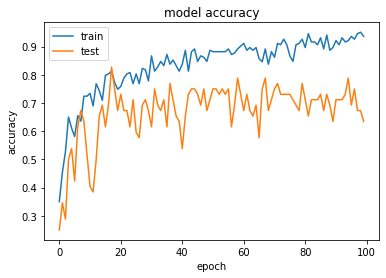

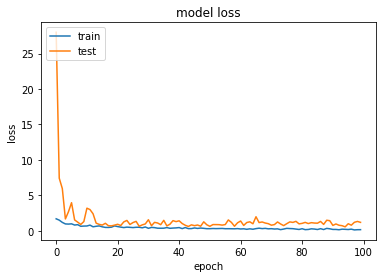

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Testing Model

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=preprocessing_fun,
                                  featurewise_center=True,
                                  featurewise_std_normalization=True)
test_datagen.mean = train_datagen.mean
test_datagen.std = train_datagen.std

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
 1/36 [..............................] - ETA: 3s - loss: 1.5258e-04 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  del sys.path[0]


36/36 [==============================] - 1s 32ms/step - loss: 0.5100 - accuracy: 0.8056
Test loss: 0.5099684596061707
Test accuracy: 0.8055555820465088


## Adding SVM classifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# creating SVM model
svm_model = OneVsRestClassifier(SVC())

# freeze last layer of plot
intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_3').output)
svm_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

y = svm_data_generator.classes

pred_train = intermediate_layer_model.predict_generator(svm_data_generator, 270, verbose=1)
X = [] # for training SVM classifier
for index, s in enumerate(pred_train):
  X.append(s)

# fitting the model with training data
svm_model.fit(X,y)

# now predict test data
y_test = eval_generator.classes
pred_test = intermediate_layer_model.predict_generator(eval_generator, len(eval_generator), verbose=1)
X_test = []
for index, s in enumerate(pred_test):
  X_test.append(s)

y_pred = svm_model.predict(X_test)

# Evaluating the Model
print(f"Test Set Accuracy : {accuracy_score(y_test,y_pred)*100} %\n\n")


Found 270 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


270/270 [==============================] - 11s 40ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


36/36 [==============================] - 1s 26ms/step
Test Set Accuracy : 77.77777777777779 %




## Adding RandomForest Classifer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(X, y)

y_pred_rf = clf.predict(X_test)

# Evaluating the Model
print(f"Test Set Accuracy : {accuracy_score(y_test,y_pred_rf)*100} %\n\n")


Test Set Accuracy : 75.0 %




## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns 
import pandas as pd

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_3').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

labels = tsne_data_generator.classes



Found 270 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


270/270 [==============================] - 8s 28ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

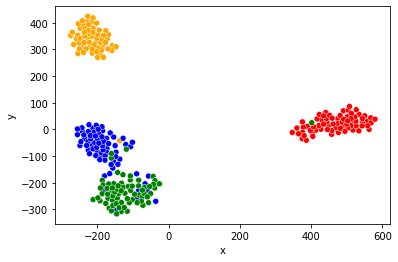

In [ ]:
pred = intermediate_layer_model.predict_generator(tsne_data_generator, 270, verbose=1)
features = []
for index, s in enumerate(pred):
  features.append(s)

embedded = TSNE(n_components=2, init='pca').fit_transform(np.array(features))

# source: https://stackoverflow.com/questions/52570086/plotting-numpy-array-using-seaborn
df = pd.DataFrame(embedded, columns=["x", "y"])
df["val"] = pd.Series(labels).apply(lambda x: "red" if x==1 else "blue" if x==2 else  "green" if x==3 else "orange")
sns.scatterplot(df["x"], df["y"], c=df["val"]).plot()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->